# Model-Free Methods

#### Model-free prediction
Estimate the value function of an unknown MDP

#### Model-free control
Optimise the value function of an unknown MDP

## Monte-Carlo Learning

* learns directly from episodes of experience
* no knowledge of MDP transitions/rewards (model-free)
* learns from complete episodes: **no bootstrapping**
* value = mean return
* requires episodic MDP (must terminate)

### First-Visit Monte-Carlo Policy Evaluation

The **first** time-step $t$ that state $s$ is visited in an episode
* Increment counter $N(s) \leftarrow N(s)+1$
* Increment total return $S(s) \leftarrow S(s)+G_t$

Value is estimated by mean return $V(s)=S(s)/N(s)$

By law of large numbers, $V(s) \rightarrow v_\pi(s)$ as $N(s)\rightarrow \infty$

### Every-Visit Monte-Carlo Policy Evaluation

**Every** time-step $t$ that state $s$ is visited in an episode
* Increment counter $N(s) \leftarrow N(s)+1$
* Increment total return $S(s) \leftarrow S(s)+G_t$

Value is estimated by mean return $V(s)=S(s)/N(s)$

By law of large numbers, $V(s) \rightarrow v_\pi(s)$ as $N(s)\rightarrow \infty$

### Incremental Monte-Carlo Updates

For each state $S_t$ with return $G_t$
* $N(S_t) \leftarrow N(S_t)+1$
* $V(S_t) \leftarrow V(S_t)+ \frac{1}{N(S_t)}(G_t-V(S_t))$

In non-stationary probles, it can be useful to track a runnning mean, i.e. forget old episodes

$$V(S_t) \leftarrow V(S_t)+\alpha(G_t-V(S_t))$$

### Code

#### Pseudo

**Initialize:**
* $\pi \leftarrow$ policy to be evaluated
* $V \leftarrow$ an arbitrary state-value function
* $Returns(s)\leftarrow$ an empty list, for all $s\in S$ - (use sum and count of returns)

**Repeat forever:**
Generate an episode using $\pi$, for each state $s$ appearing in the episode:
* $G \leftarrow$ return following the first occurrence of $s$
* Append $G$ to $Returns(s)$
* $V(s) \leftarrow average(Returns(s))$

#### Code

In [26]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
from environments.blackjack import BlackjackEnv
from utils import plot_value_function
from jupyterthemes import jtplot
jtplot.style(theme='monokai', ticks=True)

In [27]:
env = BlackjackEnv()

In [28]:
def mc_prediction(env, policy, n_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    
    for i_episode in range(1, n_episodes+1):
        # print episode (debugging)
        if i_episode%1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes), end="")
            sys.stdout.flush()
        # generate episode [(state, action, reward),...]
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # find all states visited in episode
        episode_states = set([tuple(x[0]) for x in episode])
        for state in episode_states:
            # find first occurence of s
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state)
            # sum rewards since first occurence
            G = sum([x[2]*(discount_factor**i) for i,x in
                     enumerate(episode[first_occurence_idx:])])
            # calc average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state]/returns_count[state]
    
    return V

In [29]:
def sample_policy(observation):
    # sticks if player score > 20 and hits otherwise
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

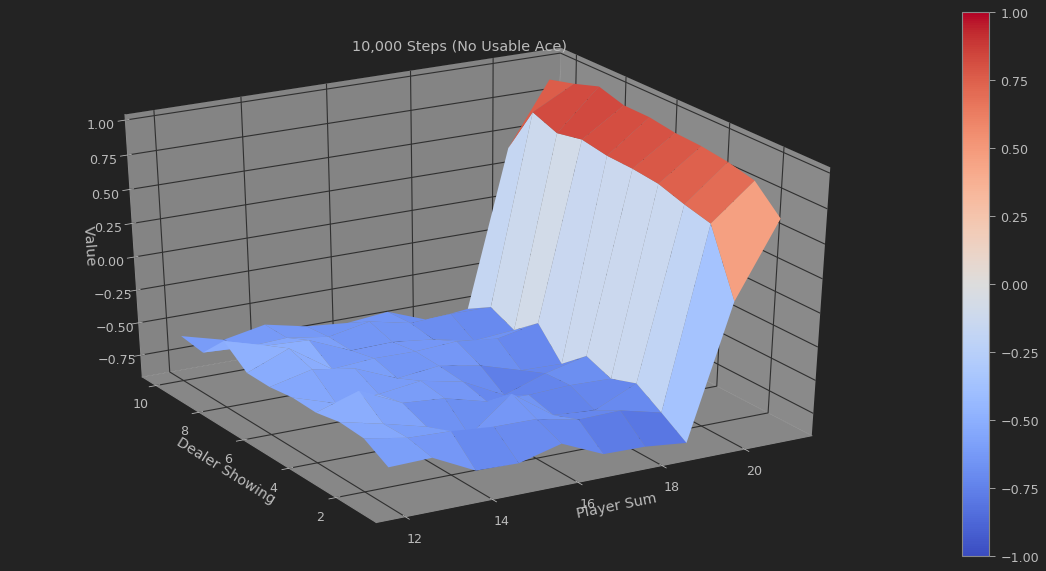

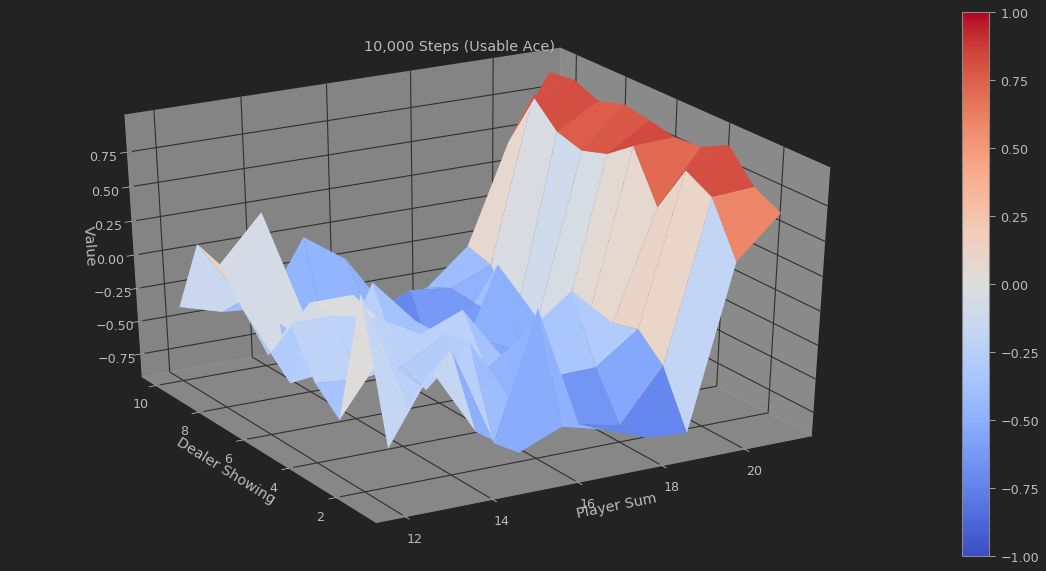

In [30]:
V_10k = mc_prediction(env, sample_policy, n_episodes=10000)
plot_value_function(V_10k, title="10,000 Steps")

Episode 500000/500000.

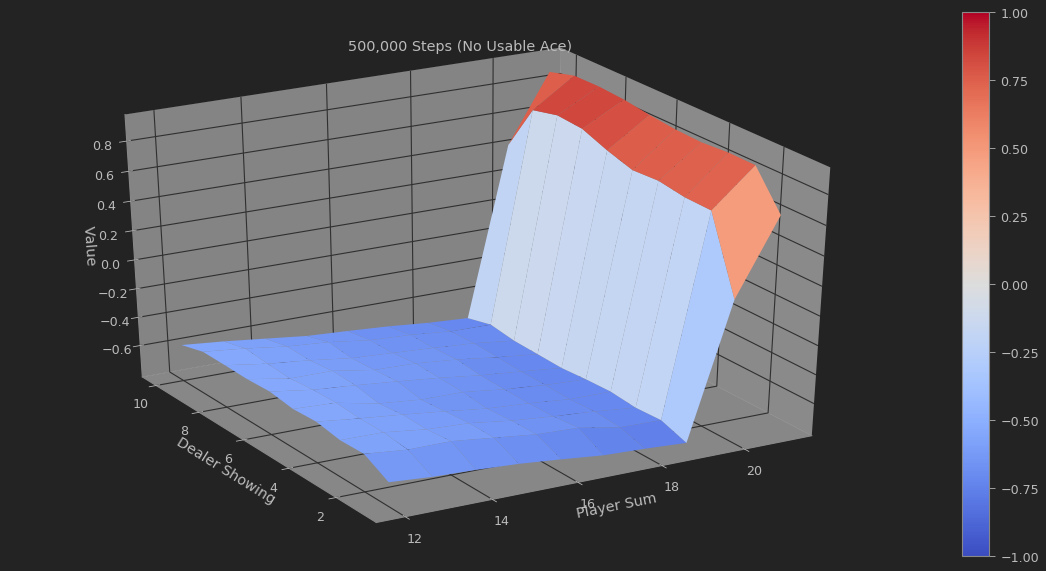

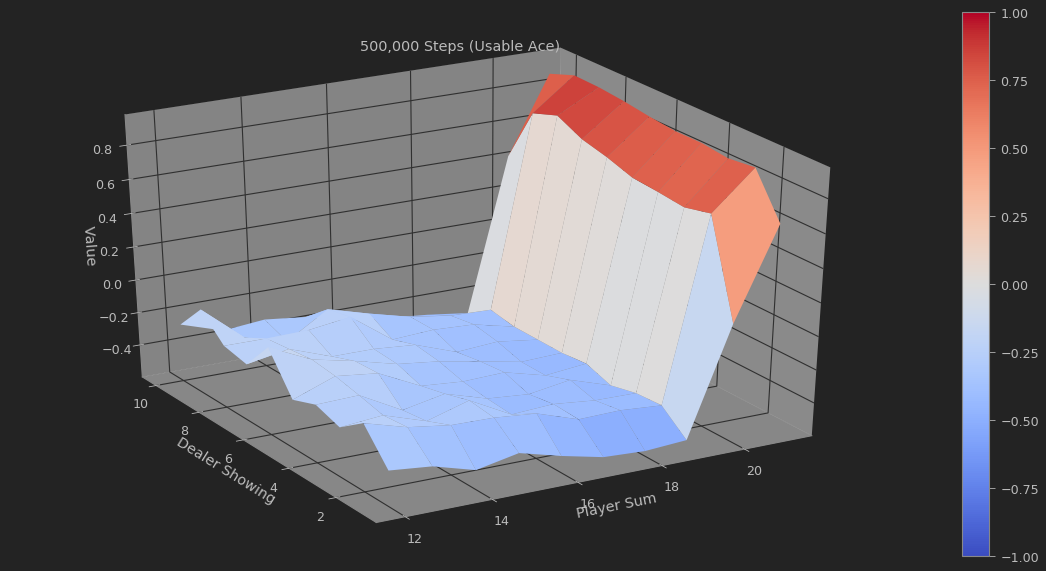

In [31]:
V_10k = mc_prediction(env, sample_policy, n_episodes=500000)
plot_value_function(V_10k, title="500,000 Steps")

## Temporal-Difference Learning

* learns directly from episodes of experience
* no knowledge of MDP transitions/rewards
* learns from incomplete episodes, by **bootstrapping**
* updates a guess towards a guess

### TD(0)

Update value $V(S_t)$ toward estimated return $R_{t+1}+\gamma V(S_{t+1})$
$$ V(S_t)\leftarrow V(S_t)+\alpha(R_{t+1}+\gamma V(S_{t+1})-V(S_t))$$

* $R_{t+1}+\gamma V(S_{t+1})$ is called the **TD target**
* $\delta_t=R_{t+1}+\gamma V(S_{t+1})-V(S_t)$ is called the **TD error**

### TD($\lambda$)

### n-Step

n-step return:
$$G_t^{(n)} = R_{t+1}+\gamma R_{t+2}+...+\gamma^{n-1}R_{t+n}+\gamma^n V(S_{t+n})$$

n-step temporal difference learning:
$$ V(S_t)\leftarrow V(S_t)+\alpha(G_t^{(n)}-V(S_t))$$

#### Forward View of TD($\lambda$)

The $\lambda$-return $G_t^\lambda$ combines all n-step returns $G_t^{(n)}$ using weight $(1-\lambda)\lambda^{n-1}$

$$ G_t^\lambda=(1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}G_t^{(n)}$$

Forward-view TD($\lambda$)
$$ V(S_t)\leftarrow V(S_t)+\alpha(G_t^\lambda-V(S_t))$$

#### Backward View of TD($\lambda$)

##### Eligibility Traces
* Frequency heuristic: assign credit to most frequent states
* Recency heurestic: assign credit to most recent states

Eligibility traces combine both heuristics
* $ E_0(s)=0 $
* $ E_t(s)=\gamma\lambda E_{t-1}(s)+\mathbb{1}(S_t=s)$

* Keep an eligibility trace for every state $s$
* Update the value $V(s)$ for every state $s$ in proportion to TD-error $\delta_t$ and eligibility trace $E_t(s)$

$$ \delta_t = R_{t+1}+\gamma V(S_{t+1})-V(S_t) $$
$$ V(s)\leftarrow V(s)+\alpha\delta_t E_t(s)$$ 

